# Sentiment Analysis of Twitter Posts
<!-- Notebook name goes here -->
<center><b>Notebook: Multinomial Logistic Regression, Error Analysis, and Tuning</b></center>
<br>

**By**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**Dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**Motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**Goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.

# **1. Project Set-up**



In [36]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    log_loss,
    make_scorer, 
    brier_score_loss
)
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath("../lib"))
from anal_ysis_tools import (
    evaluate_classifier,
    check_feature_sparsity,
    high_lift_words,
)

# **2. Data Set-up**

In [37]:
import IPython.core.page
import builtins
from IPython.utils.capture import capture_output

pager = IPython.core.page.page
helper = builtins.help

IPython.core.page.page = lambda *args, **kwargs: None
builtins.help = lambda *args, **kwargs: None

try:
    with capture_output():
        %run data.ipynb
finally:
    IPython.core.page.page = pager
    builtins.help = helper

print("Data Setup is DONE")

# Tests
assert X.shape == (162_801, 29318), "Feature matrix shape is wrong; expected (162_801, 29318)"
assert y.shape == (162_801,), "Labels shape is wrong; expected (162_801,)"

assert X_train.shape == (113_960, 29_318), "Train shape is wrong; expected (113_960, 2)"
assert X_test.shape == (48_841, 29_318), "Test shape is wrong; expected (48_841, 2)"

assert y_train.shape == (113_960,), "Train labels shape is wrong; expected (113_960,)"
assert y_test.shape == (48_841,), "Test labels shape is wrong; expected (48_841,)"
print("All tests passed.")

Data Setup is DONE
All tests passed.


# **3. Model Selection**

In [38]:
model = LogisticRegression()

# **4. Training the Model**

To check if the data separated according to the test and training size, we can check the length of `X_train` and `X_test`

In [39]:
model.fit(X_train, y_train)

C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

### Evaluation

In [40]:
model.score(X_test, y_test)

0.843369300382875

In [41]:
y_true = y_test
y_pred = model.predict(X_test)

In [42]:
evaluate_classifier(model, y_pred, y_test, show_cm=False, digits=4)

Accuracy: 0.843369300382875

Classification Report:

              precision    recall  f1-score   support

          -1     0.8142    0.7512    0.7814     10743
           0     0.8236    0.9004    0.8603     16542
           1     0.8744    0.8455    0.8597     21556

    accuracy                         0.8434     48841
   macro avg     0.8374    0.8324    0.8338     48841
weighted avg     0.8440    0.8434    0.8427     48841



array([ 0,  0,  0, ..., -1, -1,  0], shape=(48841,))

### Error Analysis

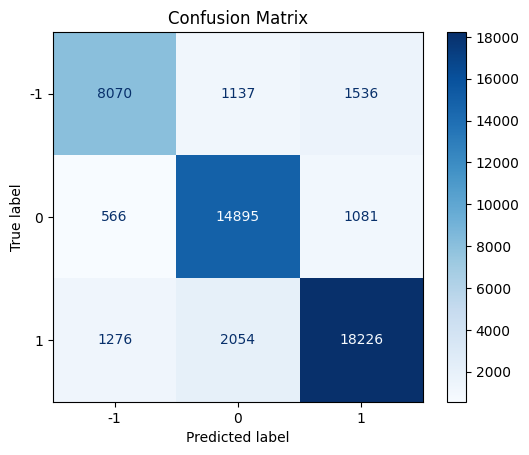

In [43]:
cm = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_pred,
    cmap='Blues',
    display_labels=[-1, 0, 1]
)
plt.title('Confusion Matrix')
plt.show()

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.81      0.75      0.78     10743
           0       0.82      0.90      0.86     16542
           1       0.87      0.85      0.86     21556

    accuracy                           0.84     48841
   macro avg       0.84      0.83      0.83     48841
weighted avg       0.84      0.84      0.84     48841



In [45]:
y_prob = model.predict_proba(X_test)
print(log_loss(y_true, y_prob))

0.47925048406234894


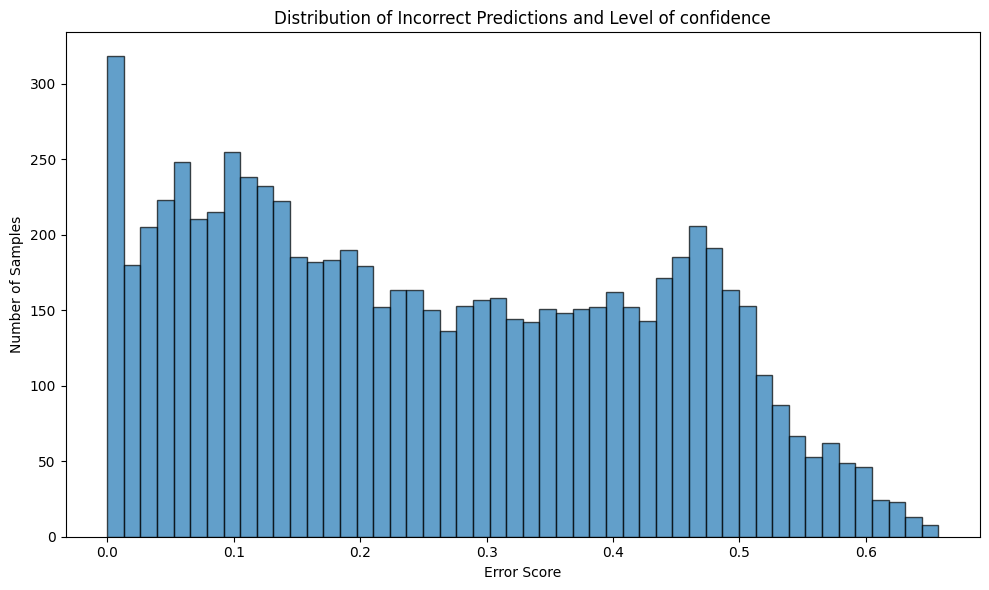

Total incorrect predictions: 7650/48841
Mean error score: 0.259


In [46]:
confidence = y_prob.max(axis=1)

incorrect_mask = y_pred != y_test.values
incorrect_confidence = confidence[incorrect_mask]

plt.figure(figsize=(10, 6))
plt.hist(1 - incorrect_confidence, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Incorrect Predictions and Level of confidence')
plt.tight_layout()
plt.show()

print(f"Total incorrect predictions: {incorrect_mask.sum()}/{len(y_pred)}")
print(f"Mean error score: {(1 - incorrect_confidence).mean():.3f}")

Most of the errors here have a low error score (and low mean error score) indicating high confidence for the wrong class prediction, possible overfitting

# **5. Model Tuning**

class sklearn.linear_model.LogisticRegression(penalty='deprecated', *, C=1.0, l1_ratio=0.0, dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, verbose=0, warm_start=False, n_jobs=None)

### Finding the best parameters

In [47]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1],
    'class_weight': [None, 'balanced'],
    'max_iter': [500, 1000,2000],
}

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=kf, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
best_model.fit(X_train, y_train)

### Evaluation


In [ ]:
best_model.score(X_test, y_test)

In [ ]:
y_true = y_test
y_pred = best_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [ ]:
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
cm = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_pred,
    cmap='Blues',
    display_labels=[-1, 0, 1]
)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
y_prob = model.predict_proba(X_test)
print(log_loss(y_true, y_prob))

In [ ]:
confidence = y_prob.max(axis=1)

incorrect_mask = y_pred != y_test.values
incorrect_confidence = confidence[incorrect_mask]

plt.figure(figsize=(10, 6))
plt.hist(1 - incorrect_confidence, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Incorrect Predictions and Level of confidence')
plt.tight_layout()
plt.show()

print(f"Total incorrect predictions: {incorrect_mask.sum()}/{len(y_pred)}")
print(f"Mean error score: {(1 - incorrect_confidence).mean():.3f}")

### Using the balanced set

In [ ]:
best_model.fit(Xb_train, yb_train)

In [ ]:
best_model.score(X_test, y_test)

In [ ]:
confidence = y_prob.max(axis=1)

incorrect_mask = y_pred != y_test.values
incorrect_confidence = confidence[incorrect_mask]

plt.figure(figsize=(10, 6))
plt.hist(1 - incorrect_confidence, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Incorrect Predictions and Level of confidence')
plt.tight_layout()
plt.show()

print(f"Total incorrect predictions: {incorrect_mask.sum()}/{len(y_pred)}")
print(f"Mean error score: {(1 - incorrect_confidence).mean():.3f}")